#### Download the Pascal-VOC dataset from [here](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#devkit)

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout main

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 322853, done.
remote: Counting objects: 100% (838/838), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 322853 (delta 687), reused 812 (delta 671), pack-reused 322015
Receiving objects: 100% (322853/322853), 654.53 MiB | 23.73 MiB/s, done.
Resolving deltas: 100% (296717/296717), done.
Already on 'main'
Your branch is up to date with 'origin/main'.


In [3]:
!mkdir traindir

In [4]:
!tar -xf "/content/drive/MyDrive/VOC2012/VOCtrainval_11-May-2012.tar" --directory "/content/traindir" --checkpoint=.100

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [5]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

## Section 1: Load Pascal-VOC dataset


In [6]:
import os
# import cv2
import numpy as np
from xml.etree import ElementTree as et
from torchvision import transforms
import collections

train_dir = '/content/traindir/VOCdevkit/VOC2012'
test_dir = '/content/testdir/VOCdevkit/VOC2012'

In [7]:
PASCAL_VOC_CLASSES = [
        'person', 
        'bird', 
        'cat', 
        'cow',
        'dog',
        'horse', 
        'sheep',
        'bottle', 
        'chair', 
        'diningtable', 
        'pottedplant', 
        'sofa', 
        'tvmonitor',
        'aeroplane', 
        'bicycle', 
        'boat', 
        'bus', 
        'car', 
        'motorbike', 
        'train'
]

In [8]:
class PascalVOCDataset(torch.utils.data.Dataset):
  def __init__(self, dataset_dir, width, height, transforms=None):
    self.transforms = transforms
    self.dataset_dir = dataset_dir
    self.height = height
    self.width = width
    self.imgs = [image for image in sorted(os.listdir(f"{dataset_dir}/JPEGImages/"))
                        if image[-4:]=='.jpg']
    self.classes = PASCAL_VOC_CLASSES

  def __getitem__(self, idx):
    img_name = self.imgs[idx]
    image_path = os.path.join(f"{self.dataset_dir}/JPEGImages/", img_name)

    img_rgb = torchvision.io.read_image(image_path)
    img_res = torchvision.transforms.functional.resize(img_rgb, [480,480],antialias=True)
    img_res = torch.div(img_res,255.0)
    annot_filename = img_name[:-4] + '.xml'
    annot_file_path = os.path.join(f"{self.dataset_dir}/Annotations/", annot_filename)
  
    boxes = []
    labels = []
    tree = et.parse(annot_file_path)
    root = tree.getroot()
    # cv2 image gives size as height x width
    wt = img_rgb.shape[2]
    ht = img_rgb.shape[1]
    # box coordinates for xml files are extracted and corrected for image size given
    for member in root.findall('object'):
        labels.append(self.classes.index(member.find('name').text))
        # bounding box
        xmin = int(float(member.find('bndbox').find('xmin').text))
        xmax = int(float(member.find('bndbox').find('xmax').text))
      
        ymin = int(float(member.find('bndbox').find('ymin').text))
        ymax = int(float(member.find('bndbox').find('ymax').text))
      
        xmin_corr = (xmin/wt)*self.width
        xmax_corr = (xmax/wt)*self.width
        ymin_corr = (ymin/ht)*self.height
        ymax_corr = (ymax/ht)*self.height
      
        boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
    
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    labels = torch.as_tensor(labels, dtype=torch.int64)
    image_id = torch.tensor([idx])
    target = {"boxes": boxes, "labels" : labels, "area" : area, "image_id" : image_id, "iscrowd":torch.tensor([0]*len(labels))} 
    return img_res,target

  def __len__(self):
        return len(self.imgs)

## Section 2: Define Pre-trained Object Detection Model

In [9]:
# Faster RCNN Model
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def getRCNNModel(num_classes):
  FasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
  for param in FasterRCNN.parameters():
    param.requires_grad = False
  in_features = FasterRCNN.roi_heads.box_predictor.cls_score.in_features
  FasterRCNN.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return FasterRCNN 

## Section 3: Prepare Dataset and Train the model



In [10]:
def collate_fn(data):
    images = []
    targets = []
    for i in data:
      images.append(i[0])
      targets.append(i[1])
    return torch.utils.data.default_collate(images), targets

In [11]:
data_set = PascalVOCDataset(train_dir, 480, 480, transforms = T.ToTensor())
print(f"Data set size:{len(data_set)}")

Data set size:17125


In [12]:
torch.manual_seed(1)
indices = torch.randperm(len(data_set)).tolist()

total_count = 2000
test_split = 0.2
tsize = int(total_count*test_split)
straindataset = torch.utils.data.Subset(data_set, indices[:(total_count-tsize)])
stestdataset = torch.utils.data.Subset(data_set, indices[-tsize:])

print(f"Splitted Train Dataset:{len(straindataset)}")
print(f"Splitted Test Dataset:{len(stestdataset)}")

Splitted Train Dataset:1600
Splitted Test Dataset:400


In [13]:
batch_size = 25
trainloader = torch.utils.data.DataLoader(straindataset, batch_size=batch_size, shuffle=True, num_workers=1, collate_fn=collate_fn)
testloader = torch.utils.data.DataLoader(stestdataset, batch_size=batch_size, shuffle=False, num_workers=1, collate_fn=collate_fn)

In [14]:
images = next(iter(testloader))
print(images[1])

[{'boxes': tensor([[ 36.4800,  98.5600, 404.1600, 467.2000]]), 'labels': tensor([12]), 'area': tensor([135541.5625]), 'image_id': tensor([2018]), 'iscrowd': tensor([0])}, {'boxes': tensor([[176.0502,  97.9200, 388.2132, 432.0000]]), 'labels': tensor([0]), 'area': tensor([70879.4219]), 'image_id': tensor([14220]), 'iscrowd': tensor([0])}, {'boxes': tensor([[416.6400, 216.3200, 432.9600, 267.5200],
        [ 74.8800, 224.0000, 106.5600, 305.9200],
        [  0.9600, 170.2400, 480.0000, 308.4800]]), 'labels': tensor([ 0,  0, 19]), 'area': tensor([  835.5825,  2595.2261, 66222.4922]), 'image_id': tensor([10572]), 'iscrowd': tensor([0, 0, 0])}, {'boxes': tensor([[  2.8800,  65.0602, 256.3200, 362.8916]]), 'labels': tensor([0]), 'area': tensor([75482.3750]), 'image_id': tensor([15300]), 'iscrowd': tensor([0])}, {'boxes': tensor([[131.5200,  80.4000, 241.9200, 457.2000]]), 'labels': tensor([0]), 'area': tensor([41598.7188]), 'image_id': tensor([14851]), 'iscrowd': tensor([0])}, {'boxes': tens

In [15]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

Device: cuda:0


In [16]:
from engine import train_one_epoch,evaluate
#TODO: Declare your hyperparameters
learning_rate = 0.005
weight_decay = 0.0005
momemtum = 0.9
num_classes = len(PASCAL_VOC_CLASSES)
PATH_FASTER_RCNN = "./faster_rcnn.pt"
num_epochs = 10
warmup_factor = 1.0 / 1000
warmup_iters = min(1000, len(trainloader) - 1)

In [17]:
# training RCNN Model
FasterRCNN = getRCNNModel(num_classes)
FasterRCNN.to(DEVICE)

params = [p for p in FasterRCNN.parameters() if p.requires_grad]

optimizer =  torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_factor, total_iters=warmup_iters)
for epoch in range(num_epochs):
        train_one_epoch(FasterRCNN, optimizer, trainloader, DEVICE, epoch, print_freq=10)
        lr_scheduler.step()
        evaluate(FasterRCNN, testloader, device=DEVICE)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 243MB/s]


Epoch: [0]  [ 0/64]  eta: 0:11:00  lr: 0.000000  loss: 3.1412 (3.1412)  loss_classifier: 2.9472 (2.9472)  loss_box_reg: 0.1486 (0.1486)  loss_objectness: 0.0352 (0.0352)  loss_rpn_box_reg: 0.0101 (0.0101)  time: 10.3208  data: 0.6463  max mem: 6483
Epoch: [0]  [10/64]  eta: 0:02:31  lr: 0.000001  loss: 3.1340 (3.1288)  loss_classifier: 2.9268 (2.9315)  loss_box_reg: 0.1576 (0.1693)  loss_objectness: 0.0177 (0.0187)  loss_rpn_box_reg: 0.0100 (0.0092)  time: 2.8095  data: 0.1281  max mem: 6499
Epoch: [0]  [20/64]  eta: 0:01:49  lr: 0.000002  loss: 3.1154 (3.1331)  loss_classifier: 2.9166 (2.9243)  loss_box_reg: 0.1737 (0.1792)  loss_objectness: 0.0181 (0.0204)  loss_rpn_box_reg: 0.0090 (0.0093)  time: 2.1006  data: 0.0814  max mem: 6499
Epoch: [0]  [30/64]  eta: 0:01:21  lr: 0.000002  loss: 3.1154 (3.1252)  loss_classifier: 2.9062 (2.9168)  loss_box_reg: 0.1815 (0.1785)  loss_objectness: 0.0194 (0.0212)  loss_rpn_box_reg: 0.0077 (0.0087)  time: 2.1558  data: 0.0810  max mem: 6499
Epoch: 

In [18]:
torch.save(FasterRCNN.state_dict(), PATH_FASTER_RCNN)

In [19]:
FasterRCNN = getRCNNModel(num_classes)
FasterRCNN.load_state_dict(torch.load(PATH_FASTER_RCNN))
FasterRCNN.to(DEVICE)
evaluate(FasterRCNN, testloader, device=DEVICE)

creating index...
index created!
Test:  [ 0/16]  eta: 0:00:43  model_time: 2.2113 (2.2113)  evaluator_time: 0.0475 (0.0475)  time: 2.7288  data: 0.4463  max mem: 7048
Test:  [15/16]  eta: 0:00:02  model_time: 2.3067 (2.3103)  evaluator_time: 0.0390 (0.0602)  time: 2.4924  data: 0.0940  max mem: 7048
Test: Total time: 0:00:39 (2.4955 s / it)
Averaged stats: model_time: 2.3067 (2.3103)  evaluator_time: 0.0390 (0.0602)
Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.157
 Average Recall     (AR) @[ IoU=

## Section 4: Test the model

In [20]:
import matplotlib.patches as patches
from torchvision import transforms as torchtrans  

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        a.add_patch(rect)
    plt.show()

def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

def apply_nms(orig_prediction, iou_thresh=0.3):
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

{'boxes': tensor([[ 36.4800,  98.5600, 404.1600, 467.2000]]), 'labels': tensor([12]), 'area': tensor([135541.5625]), 'image_id': tensor([2018]), 'iscrowd': tensor([0])}


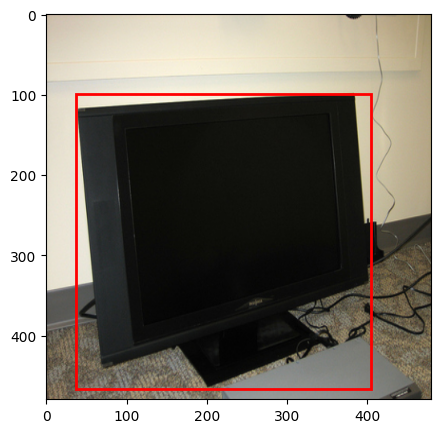

In [21]:
image_index = 0
print(images[1][image_index])
plot_img_bbox(torch_to_pil(images[0][image_index]), images[1][image_index])

In [22]:
images = next(iter(testloader))
print(images[0][0].shape)

torch.Size([3, 480, 480])


In [24]:
cpu_device = torch.device("cpu")
modelFasterRCNN = getRCNNModel(num_classes)
modelFasterRCNN.load_state_dict(torch.load(PATH_FASTER_RCNN))
modelFasterRCNN.to(cpu_device)
modelFasterRCNN.eval()
output = modelFasterRCNN(images[0])

{'boxes': tensor([[  0.0000, 172.1653, 324.0268, 304.9964]], grad_fn=<IndexBackward0>), 'labels': tensor([19]), 'scores': tensor([0.1102], grad_fn=<IndexBackward0>)}
{'boxes': array([[  0.     , 172.16534, 324.02682, 304.9964 ]], dtype=float32), 'labels': array([19]), 'scores': array([0.1102245], dtype=float32)}


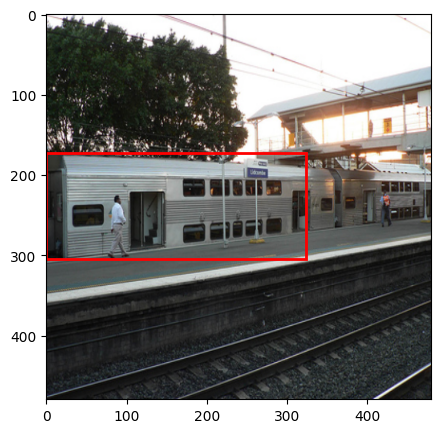

['train']
['person', 'person', 'train']


In [34]:
image_index= 2
outputOfNMS = apply_nms(output[image_index], iou_thresh=0.10)
print(outputOfNMS)
outputOfNMS = { k:v.detach().numpy() for k,v in outputOfNMS.items() }
print(outputOfNMS)
plot_img_bbox(torch_to_pil(images[0][image_index]), outputOfNMS)
print([ PASCAL_VOC_CLASSES[i] for i in outputOfNMS["labels"]])
print([ PASCAL_VOC_CLASSES[i] for i in images[1][image_index]["labels"]])

## Section 2: YOLO Model

In [28]:
# You don't have to train the model or preprocess the images. Just compile the code below and note down the metrics for comparison with Faster-RCNN.
!git clone https://github.com/ultralytics/yolov5.git

%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15598, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 15598 (delta 98), reused 115 (delta 54), pack-reused 15393
Receiving objects: 100% (15598/15598), 14.64 MiB | 31.49 MiB/s, done.
Resolving deltas: 100% (10626/10626), done.
/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00


In [29]:

!python train.py --img 640 --epochs 3 --data VOC.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=VOC.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-155-g8ecc727 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, an

In [31]:
!python val.py --weights "runs/train/exp/weights/best.pt" --data VOC.yaml --img 640

val: data=/content/yolov5/data/VOC.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-155-g8ecc727 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7064065 parameters, 0 gradients, 15.9 GFLOPs
val: Scanning /content/datasets/VOC/labels/test2007.cache... 4952 images, 0 backgrounds, 0 corrupt: 100% 4952/4952 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 155/155 [01:10<00:00,  2.21it/s]
                   all       4952      12032      0.739      0.737      0.789      0.505
             aeroplane       4952    

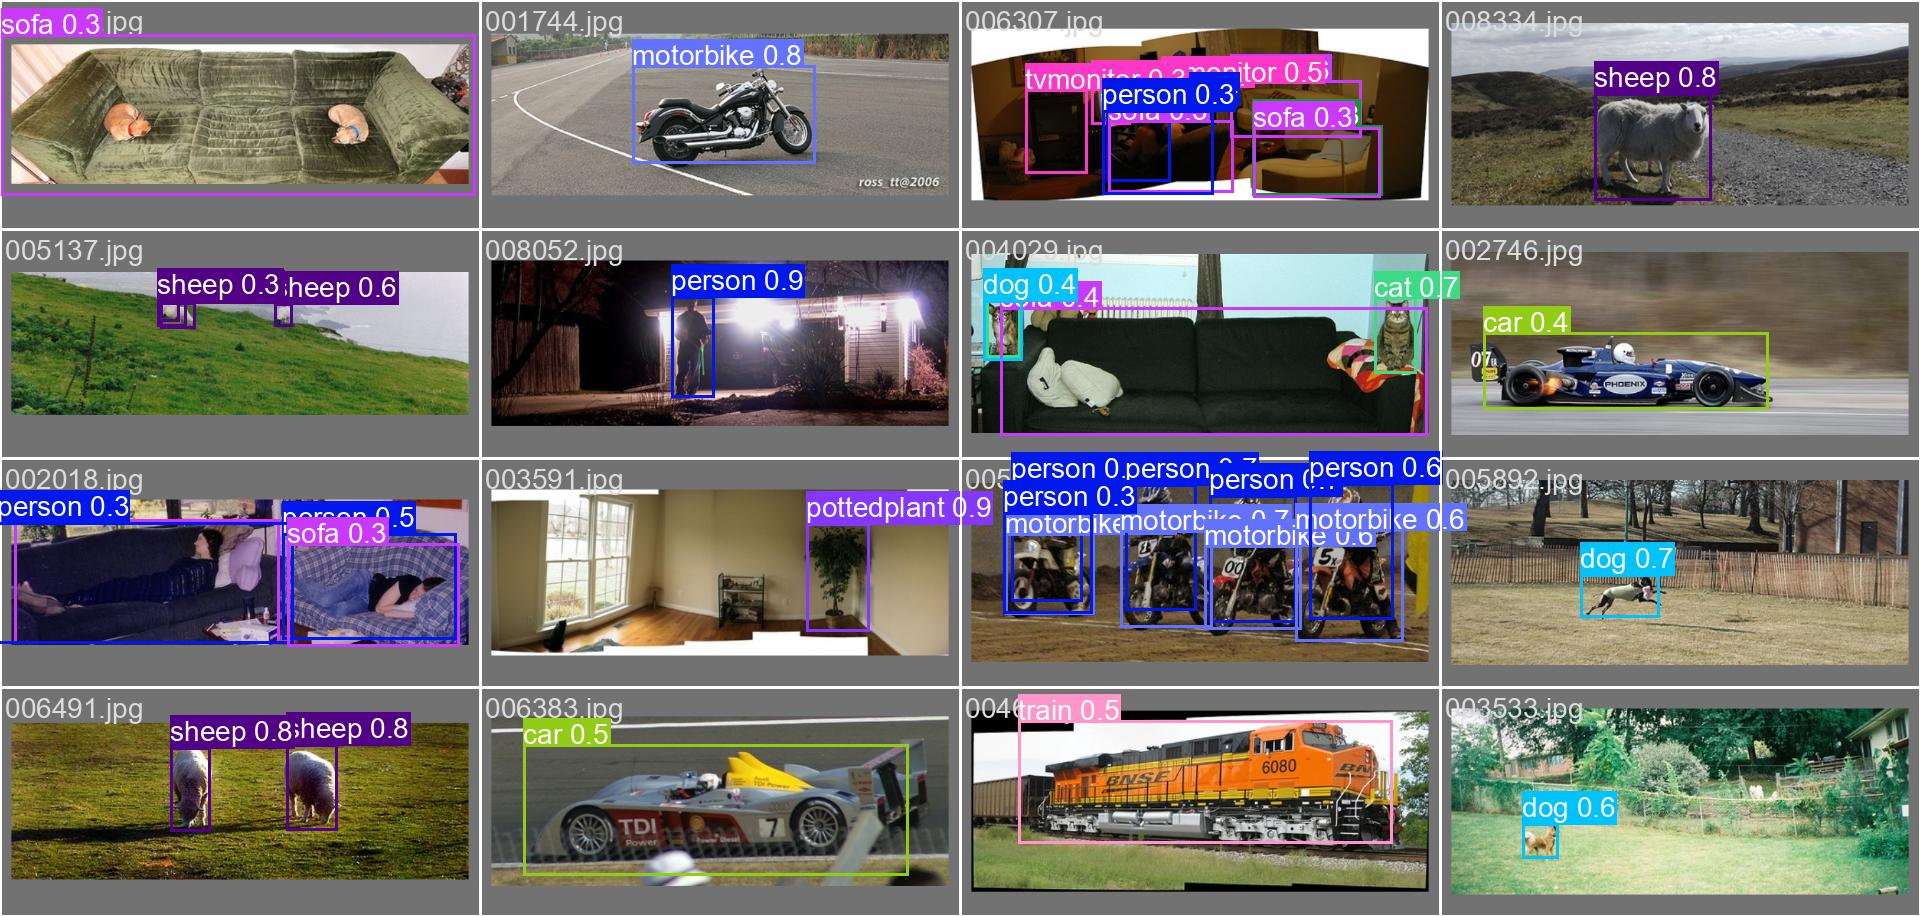

In [33]:
import cv2
from google.colab.patches import cv2_imshow
im2 = cv2.imread('/content/yolov5/runs/val/exp/val_batch0_pred.jpg')
cv2_imshow(im2)